## Imports


In [207]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.onnx

## Data loading

In [208]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")


In [209]:
df.shape

(4898, 12)

In [210]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Check if there are any NaN values

In [212]:
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [213]:
fig = px.histogram(df,x='quality')
fig.show()

AttributeError: module 'matplotlib' has no attribute 'show'

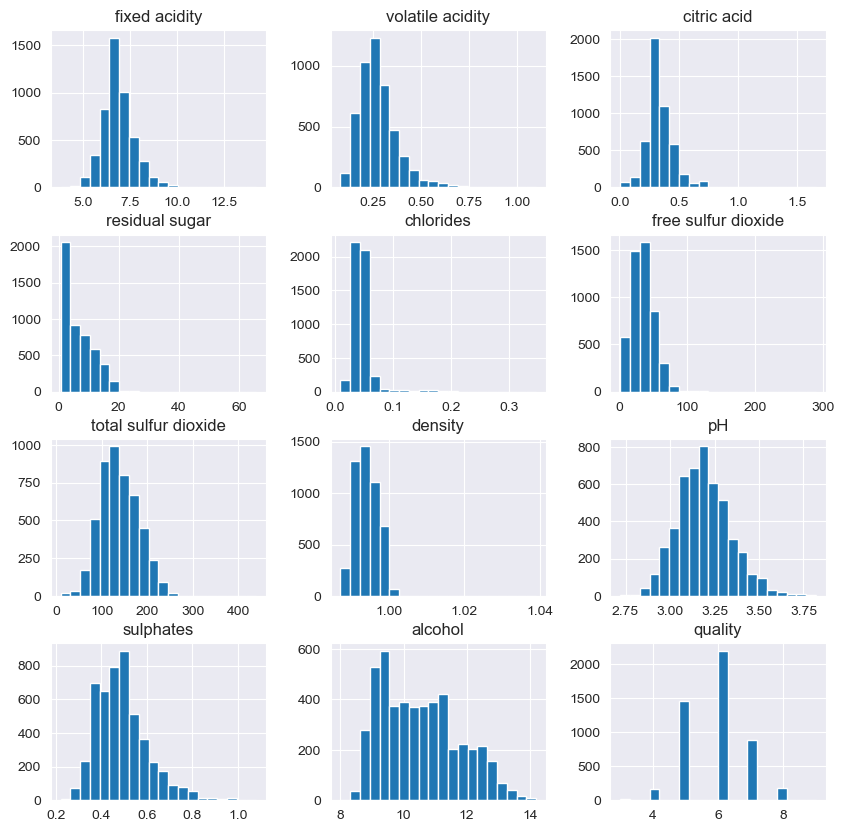

In [214]:

df.hist(bins=20, figsize=(10, 10))
plt.show()

In [ ]:
corr = df.corr()
plt.pyplot.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
# train=df.sample(frac=0.8,random_state=200) #random state is a seed value
# test=df.drop(train.index)
# x_train = train.values[:,:-1]
# y_train = train.values[:,-1]
# x_test = test.values[:,:-1]
# y_test = test.values[:,-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
x = df.values[:,:-1]
y = df.values[:,-1]
x_norm = StandardScaler().fit_transform(x)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, train_size=0.8, random_state=200)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200) # 0.25 x 0.8 = 0.2



In [ ]:
import torch.utils.data as data

In [ ]:
train_dataset = data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
next(iter(train_dataset))

In [ ]:
train_data_loader = data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
import torch.nn as nn

In [ ]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.activ_func = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ_func(x)
        x = self.linear2(x)

        return x

In [ ]:
model = SimpleClassifier(num_inputs=11, num_hidden=16, num_outputs=1)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_module = nn.MSELoss()

In [ ]:
model.train()

for epoch in range(100):
    for data_input, data_target in train_data_loader:
        optimizer.zero_grad()
        predictions = model(data_input.float())
        predictions = predictions.squeeze(dim=1)
        loss = loss_module(predictions, data_target.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    # scheduler.step()

In [ ]:
test_dataset = data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
next(iter(test_dataset))

In [ ]:
test_data_loader = data.DataLoader(test_dataset, batch_size=10, shuffle=True, drop_last=True)

In [ ]:
model.eval()
true_predictions, number_of_predictions = 0., 0.

with torch.no_grad():
    for data_input, data_target in test_data_loader:
        predictions = model(data_input.float())
        predictions = predictions.squeeze(dim=1)
        predictions = torch.round(predictions)
        true_predictions += (predictions == data_target).sum()
        number_of_predictions += data_target.shape[0]

acc = true_predictions / number_of_predictions
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
state_dict = model.state_dict()
print(state_dict)

In [ ]:
torch.save(state_dict, "wine1.tar")

In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("wine1.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=11, num_hidden=16, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.cpu().state_dict())
print("\nLoaded model\n", new_model.state_dict())

In [ ]:
onnx_input = torch.tensor([7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8])
expected_label = 6.

In [ ]:
input_names = df.columns[:-1]
output_names = df.columns[-1]
print(input_names, output_names)

In [ ]:
torch.onnx.export(model, onnx_input, 'wine_model.onnx', export_params=True, input_names=['input'], output_names=['output'])